In [1]:
import networkx as nx
import pandas as pd
from dowhy import gcm
from dowhy import CausalModel
import numpy as np
import matplotlib.pyplot as plt

from dowhy.utils import plot, bar_plot

from dowhy.gcm.falsify import FalsifyConst, falsify_graph, plot_local_insights, run_validations, apply_suggestions
from dowhy.gcm.independence_test.generalised_cov_measure import generalised_cov_based
from dowhy.gcm.util import plot
from dowhy.gcm.util.general import set_random_seed
from dowhy.gcm.ml import SklearnRegressionModel

In [2]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../Datasets/Networkwise/consolidated_5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)


consolidated = consolidated.drop(columns=['experiment', 'topology'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
# consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
# consolidated.head(100)

consolidateddiff = consolidated.dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'messageOverhead', 'topics', 'topicSize']]


# X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
# consolidated = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

#Rearrange columns according to nodes list
# nodes = causal_graph.nodes

# X = consolidated[['d', 'messageReceived', 'graft', 'prune', 'iwant', 'dlo', 'dhi', 'dscore', 'dlazy', 'ihave', 'dout', 'gossipFactor', 'interval', 'messageOverhead']].to_numpy()

# X = consolidated.to_numpy()
# print(X)
consolidated.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,messageOverhead,topics,topicSize
0,8,43.0,0.0,0.0,6,12,2,321.0,1,16
1,8,54.0,0.0,0.0,6,12,2,389.0,1,16
2,8,96.0,0.0,0.0,6,12,2,702.0,1,16
3,8,88.0,0.0,0.0,6,12,2,629.0,1,16
4,8,61.0,0.0,0.0,6,12,2,454.0,1,16
...,...,...,...,...,...,...,...,...,...,...
495,16,18.0,0.0,0.0,8,20,4,62.0,1,16
496,16,56.0,0.0,0.0,8,20,4,250.0,1,16
497,16,50.0,0.0,0.0,8,20,4,175.0,1,16
498,16,58.0,0.0,0.0,8,20,4,239.0,1,16


# Classical

In [3]:
causal_graph = nx.read_adjlist("../../1_Discovery/MessageOverhead/AdjLists/pcClassic5s.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))

Test permutations of given graph:   0%|          | 0/20 [00:00<?, ?it/s]/home/flav/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph: 100%|██████████| 20/20 [26:56<00:00, 80.85s/it]


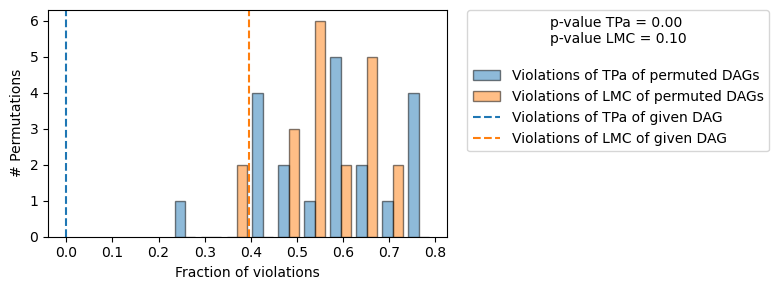

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 19/48 LMCs and is better than 90.0% of the permuted DAGs (p-value: 0.10).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we reject the DAG.                                                                                    |
+-------------------------------------------------------------------------------------------------------+


In [4]:
#Falsification

result = falsify_graph(causal_graph, consolidated, show_progress_bar=True,  plot_histogram=True)
print(result)

Violations of LMCs


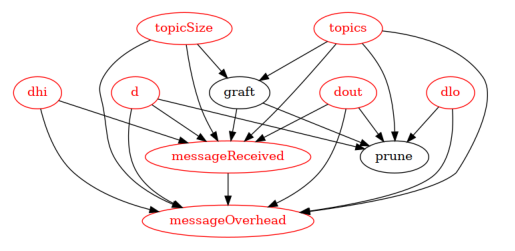

In [5]:
print('Violations of LMCs')
plot_local_insights(causal_graph, result, method=FalsifyConst.VALIDATE_LMC)

In [6]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'prune', 'messageOverhead', 'graft', 'dlo', 'dhi', 'dout', 'topics', 'topicSize']


In [7]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

consolidated = consolidated.dropna()
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
print(summary_auto_assignment)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


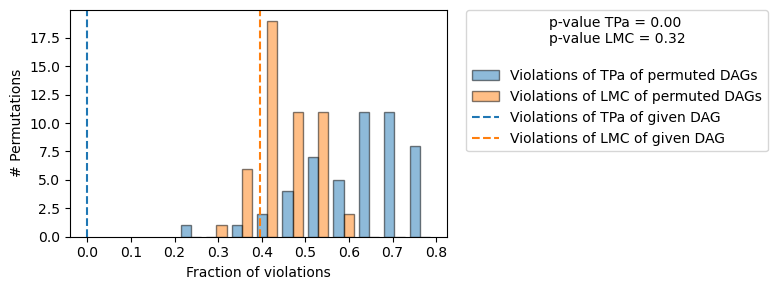

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [8]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

# Stable

In [18]:
causal_graph = nx.read_adjlist("../../1_Discovery/MessageOverhead/AdjLists/pcStable5s.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))

In [19]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'prune', 'messageOverhead', 'graft', 'dlo', 'dhi', 'dout', 'topics', 'topicSize']


Test permutations of given graph:   5%|▌         | 1/20 [01:33<29:41, 93.75s/it]/home/flav/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph: 100%|██████████| 20/20 [30:21<00:00, 91.06s/it]


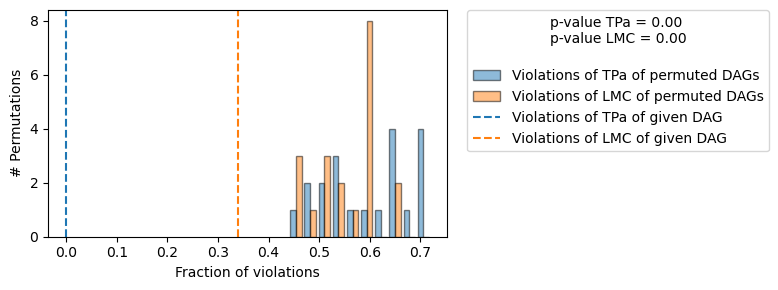

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 17/50 LMCs and is better than 100.0% of the permuted DAGs (p-value: 0.00).     |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [20]:
#Falsification

result = falsify_graph(causal_graph, consolidated, show_progress_bar=True,  plot_histogram=True)
print(result)

Violations of LMCs


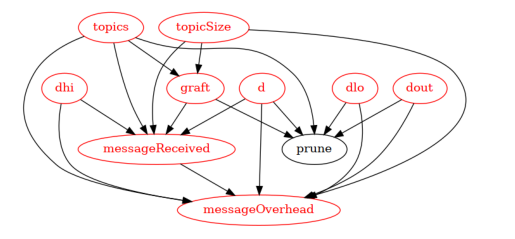

In [21]:
print('Violations of LMCs')
plot_local_insights(causal_graph, result, method=FalsifyConst.VALIDATE_LMC)

In [22]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

consolidated = consolidated.dropna()
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
print(summary_auto_assignment)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph: 100%|██████████| 50/50 [01:07<00:00,  1.35s/it]


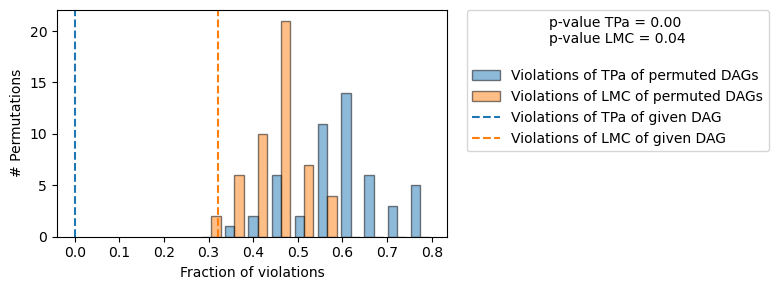

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [23]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))

# Parallel

In [3]:
causal_graph = nx.read_adjlist("../../1_Discovery/MessageOverhead/AdjLists/pcParallel5s.adjlist", create_using=nx.DiGraph)

gml_graph = "\n".join(nx.generate_gml(causal_graph))

In [4]:
#From digraph to adjancency matrix

# true_causal_matrix = nx.adjacency_matrix(causal_graph)
true_causal_matrix = nx.to_numpy_array(causal_graph)

print(true_causal_matrix)
print(causal_graph.nodes)

[[0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]]
['d', 'messageReceived', 'prune', 'messageOverhead', 'graft', 'dlo', 'dhi', 'dout', 'topics', 'topicSize']


Test permutations of given graph: 100%|██████████| 20/20 [37:11<00:00, 111.56s/it]


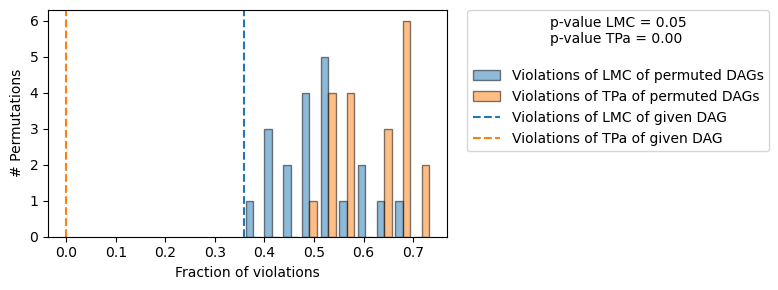

+-------------------------------------------------------------------------------------------------------+
|                                         Falsificaton Summary                                          |
+-------------------------------------------------------------------------------------------------------+
| The given DAG is informative because 0 / 20 of the permutations lie in the Markov                     |
| equivalence class of the given DAG (p-value: 0.00).                                                   |
| The given DAG violates 19/53 LMCs and is better than 95.0% of the permuted DAGs (p-value: 0.05).      |
| Based on the provided significance level (0.05) and because the DAG is informative,                   |
| we do not reject the DAG.                                                                             |
+-------------------------------------------------------------------------------------------------------+


In [6]:
#Falsification

result = falsify_graph(causal_graph, consolidated, show_progress_bar=True,  plot_histogram=True)
print(result)

Violations of LMCs


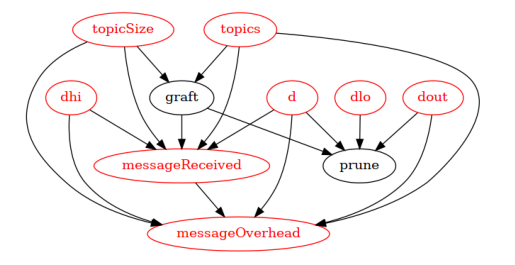

In [7]:
print('Violations of LMCs')
plot_local_insights(causal_graph, result, method=FalsifyConst.VALIDATE_LMC)

In [8]:
from scipy.stats import halfnorm

causal_model = gcm.StructuralCausalModel(causal_graph)

consolidated = consolidated.dropna()
summary_auto_assignment = gcm.auto.assign_causal_mechanisms(causal_model, consolidated)
print(summary_auto_assignment)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

Test permutations of given graph:  10%|█         | 5/50 [00:08<01:10,  1.58s/it]/home/flav/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Test permutations of given graph: 100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


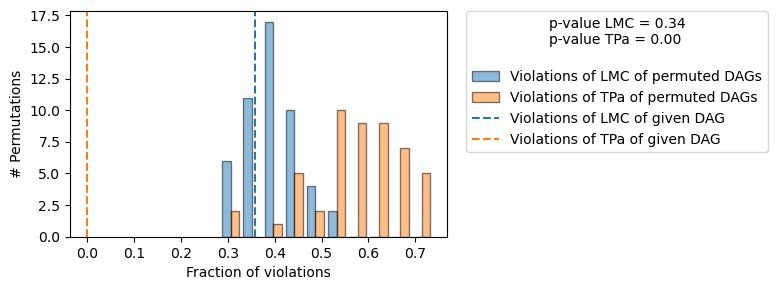

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [9]:
gcm.fit(causal_model, consolidated)
print(gcm.evaluate_causal_model(causal_model, consolidated))